In [1]:
# Step 1: Basic Imports

import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Dict


In [2]:
# Step 2: Define a simulated software system with hidden failure probabilities

class SoftwareSystem:
    def __init__(self, num_modules=10):
        """
        num_modules: number of software modules (M1, M2, ..., Mn)
        Each module has a hidden probability of failure.
        """
        self.num_modules = num_modules

        # Hidden failure probabilities for each module
        # RL does NOT see these values
        self.failure_probs = np.random.uniform(0.05, 0.5, size=num_modules)

        # Track which modules have been tested at least once
        self.coverage = np.zeros(num_modules, dtype=int)

    def run_test(self, module_id):
        """
        module_id: index of module to test (0 to num_modules-1)
        returns: 1 if failure found, 0 if test passes
        """
        self.coverage[module_id] = 1  # Mark module as covered

        prob = self.failure_probs[module_id]
        failure = np.random.rand() < prob  # Simulate failure event

        return 1 if failure else 0

    def get_coverage(self):
        """Returns percentage of modules tested at least once."""
        return np.mean(self.coverage) * 100

    def reveal_failure_probs(self):
        """For analysis only — not used by RL during training."""
        return self.failure_probs


In [3]:
# Step 3: Test Case Generator Agent

class TestCaseGeneratorAgent:
    def __init__(self, system: SoftwareSystem):
        self.system = system

    def generate_test_case(self, module_id):
        """
        A test case is simply a dictionary describing:
        - which module to test
        - any parameters (future expansion)

        Currently returns minimal structure.
        """
        test_case = {
            "module_to_test": module_id,
            "parameters": {}  # Placeholder for future complexity
        }
        return test_case


In [4]:
# Step 4: Error Detector Agent

class ErrorDetectorAgent:
    def __init__(self, system: SoftwareSystem):
        self.system = system

    def evaluate(self, test_case):
        """
        Executes the test case and checks for failure.

        Returns:
            1 -> failure detected
            0 -> test passed
        """
        module_id = test_case["module_to_test"]
        result = self.system.run_test(module_id)
        return result


In [5]:
# Step 5: Coverage Analyzer Agent

class CoverageAnalyzerAgent:
    def __init__(self, system: SoftwareSystem):
        self.system = system

    def get_coverage(self):
        """
        Returns current coverage percentage across modules.
        """
        return self.system.get_coverage()

    def get_untested_modules(self):
        """
        Returns a list of modules that have not been tested yet.
        Helpful for exploration or analysis.
        """
        return np.where(self.system.coverage == 0)[0].tolist()


In [6]:
# Step 6: RL Controller Agent using UCB exploration

class RLControllerAgent:
    def __init__(self, num_modules, exploration_weight=1.4):
        self.num_modules = num_modules
        self.exploration_weight = exploration_weight

        # Track rewards and counts for each module
        self.module_rewards = np.zeros(num_modules)
        self.module_counts = np.zeros(num_modules)

        self.total_tests = 0

    def select_module_ucb(self):
        """
        Selects a module using the UCB exploration strategy.
        """
        self.total_tests += 1

        ucb_values = np.zeros(self.num_modules)

        for i in range(self.num_modules):
            if self.module_counts[i] == 0:
                # Encourage exploring never-tested modules
                ucb_values[i] = float('inf')
            else:
                avg_reward = self.module_rewards[i] / self.module_counts[i]
                exploration_term = self.exploration_weight * np.sqrt(
                    np.log(self.total_tests) / self.module_counts[i]
                )
                ucb_values[i] = avg_reward + exploration_term

        # Choose module with highest UCB value
        return np.argmax(ucb_values)

    def update(self, module_id, reward):
        """
        Updates reward statistics after each test.

        reward = 1 if failure found
        reward = 0 if test passed
        """
        self.module_rewards[module_id] += reward
        self.module_counts[module_id] += 1

    def get_module_stats(self):
        return {
            "rewards": self.module_rewards,
            "counts": self.module_counts
        }


In [7]:
# Step 7: Full Multi-Agent RL Training Loop

def train_failure_detection_system(
    num_modules=10,
    episodes=1000,
    exploration_weight=1.4
):

    # Initialize system and agents
    system = SoftwareSystem(num_modules=num_modules)
    test_gen = TestCaseGeneratorAgent(system)
    error_detector = ErrorDetectorAgent(system)
    coverage_agent = CoverageAnalyzerAgent(system)
    rl_agent = RLControllerAgent(num_modules, exploration_weight)

    # For plotting and analysis
    rewards_over_time = []
    coverage_over_time = []

    for episode in range(episodes):

        # RL chooses module using UCB
        module_to_test = rl_agent.select_module_ucb()

        # Test Case Generator creates structured test case
        test_case = test_gen.generate_test_case(module_to_test)

        # Error Detector executes test case and returns reward (1=fail, 0=pass)
        reward = error_detector.evaluate(test_case)

        # RL Agent updates knowledge
        rl_agent.update(module_to_test, reward)

        # Log metrics
        rewards_over_time.append(reward)
        coverage_over_time.append(coverage_agent.get_coverage())

    return {
        "rl_agent": rl_agent,
        "system": system,
        "rewards_over_time": rewards_over_time,
        "coverage_over_time": coverage_over_time
    }


In [8]:
# Step 8: Plot Learning Curves

def plot_results(results):

    rewards = results["rewards_over_time"]
    coverage = results["coverage_over_time"]

    plt.figure(figsize=(14, 6))

    # -------- Plot 1: Failure Discovery Reward Curve --------
    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.6)
    plt.title("Failure Discovery Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Reward (1 = Failure, 0 = Pass)")
    plt.grid(True)

    # -------- Plot 2: Coverage Curve --------
    plt.subplot(1, 2, 2)
    plt.plot(coverage, color='green')
    plt.title("Coverage Improvement Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Coverage (%)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


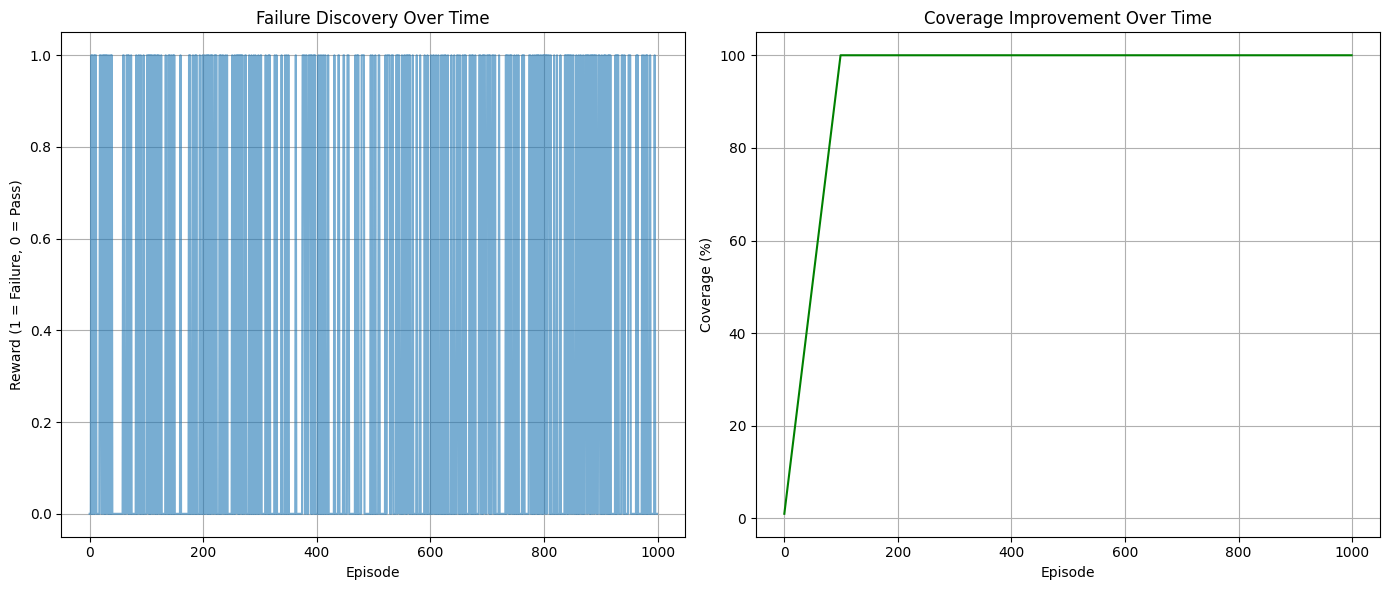

In [29]:
# Step 9: Run the training and plot results

results = train_failure_detection_system(
    num_modules=100,
    episodes=1000,
    exploration_weight=1.4
)

plot_results(results)


In [30]:
# Step 10: Improved visualization with moving average

def plot_smoothed_results(results, window=50):

    rewards = np.array(results["rewards_over_time"])
    coverage = np.array(results["coverage_over_time"])

    # Moving average for reward smoothing
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(14, 6))

    # -------- Plot 1: Smoothed Failure Discovery Curve --------
    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.2, label="Raw Rewards")
    plt.plot(smoothed_rewards, color='red', label=f"{window}-Episode Moving Avg")
    plt.title("Failure Discovery Trend (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Failure Reward")
    plt.legend()
    plt.grid(True)

    # -------- Plot 2: Coverage Curve --------
    plt.subplot(1, 2, 2)
    plt.plot(coverage, color='green')
    plt.title("Coverage Improvement Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Coverage (%)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


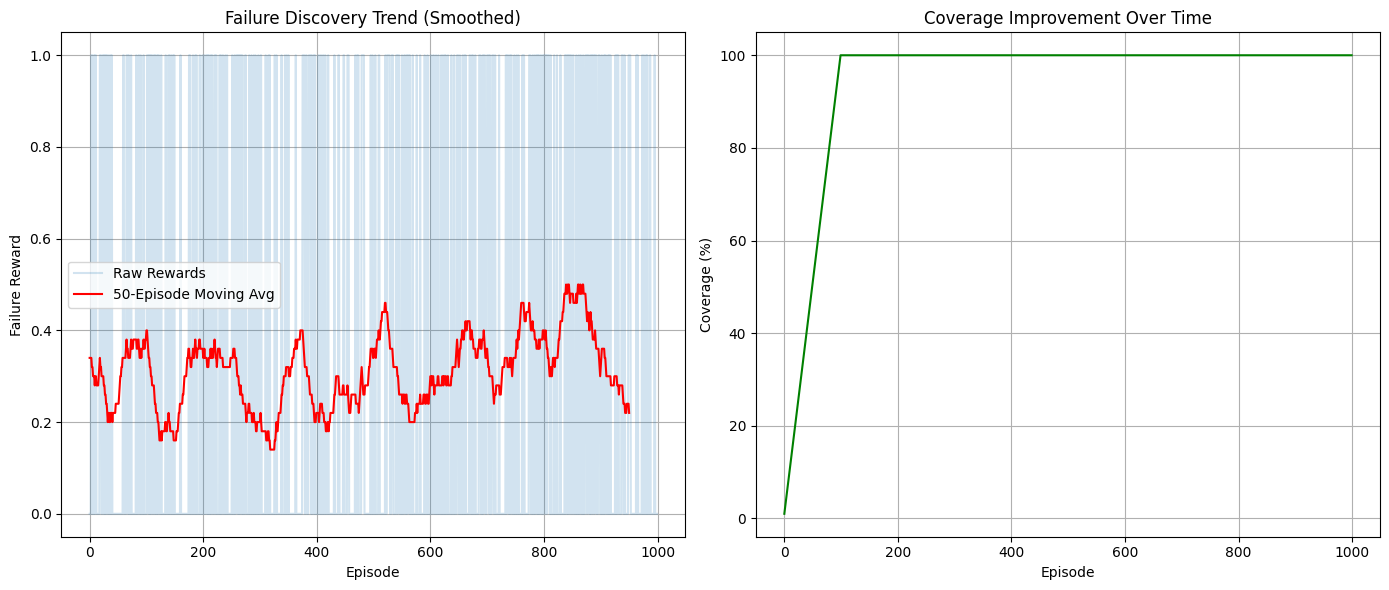

In [31]:
plot_smoothed_results(results)

In [12]:
# Step 11: Random Testing Baseline for Comparison

def run_random_baseline(num_modules=10, episodes=1000):

    system = SoftwareSystem(num_modules=num_modules)
    test_gen = TestCaseGeneratorAgent(system)
    error_detector = ErrorDetectorAgent(system)
    coverage_agent = CoverageAnalyzerAgent(system)

    rewards = []
    coverage = []

    for episode in range(episodes):
        # Randomly select a module instead of using RL
        module_id = np.random.randint(0, num_modules)

        test_case = test_gen.generate_test_case(module_id)
        reward = error_detector.evaluate(test_case)

        rewards.append(reward)
        coverage.append(coverage_agent.get_coverage())

    return {
        "rewards_over_time": rewards,
        "coverage_over_time": coverage,
        "system": system
    }


In [32]:
random_results = run_random_baseline(
    num_modules=100,
    episodes=1000
)


In [33]:
def plot_rl_vs_random(rl_results, random_results):

    rl_rewards = np.array(rl_results["rewards_over_time"])
    random_rewards = np.array(random_results["rewards_over_time"])

    rl_cumulative = np.cumsum(rl_rewards)
    random_cumulative = np.cumsum(random_rewards)

    plt.figure(figsize=(10, 6))
    plt.plot(rl_cumulative, label="RL (UCB)", linewidth=2)
    plt.plot(random_cumulative, label="Random Testing", linewidth=2)
    plt.title("Cumulative Failures Found: RL vs Random")
    plt.xlabel("Episode")
    plt.ylabel("Total Failures Found")
    plt.legend()
    plt.grid(True)
    plt.show()


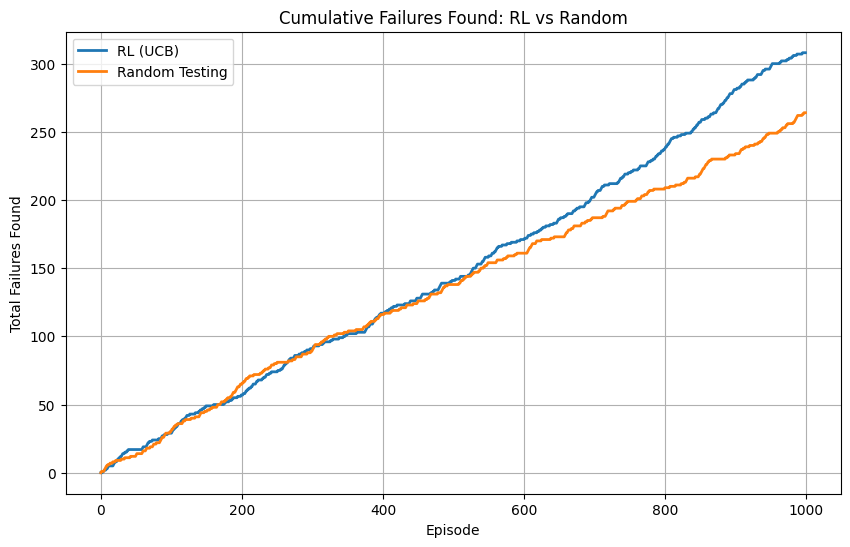

In [34]:
plot_rl_vs_random(results, random_results)


In [35]:
# Step 12: Analyze module failure statistics

def analyze_module_failures(rl_results):

    rl_agent = rl_results["rl_agent"]
    system = rl_results["system"]

    rewards = rl_agent.module_rewards
    counts = rl_agent.module_counts
    true_probs = system.reveal_failure_probs()

    print("\n=== Module Failure Analysis ===")
    print("Module | Tests | Failures | Empirical Failure Rate | True Failure Prob")
    print("----------------------------------------------------------------------")

    for i in range(len(counts)):
        empirical_rate = rewards[i] / counts[i] if counts[i] > 0 else 0
        print(f"{i:6} | {counts[i]:5.0f} | {rewards[i]:8.0f} | {empirical_rate:22.3f} | {true_probs[i]:17.3f}")

    return rewards, counts, true_probs


In [36]:
module_rewards, module_counts, true_probs = analyze_module_failures(results)



=== Module Failure Analysis ===
Module | Tests | Failures | Empirical Failure Rate | True Failure Prob
----------------------------------------------------------------------
     0 |     7 |        0 |                  0.000 |             0.074
     1 |    10 |        3 |                  0.300 |             0.244
     2 |     7 |        0 |                  0.000 |             0.167
     3 |     8 |        1 |                  0.125 |             0.170
     4 |     7 |        0 |                  0.000 |             0.068
     5 |    16 |        9 |                  0.562 |             0.362
     6 |     8 |        1 |                  0.125 |             0.320
     7 |    11 |        4 |                  0.364 |             0.491
     8 |    15 |        8 |                  0.533 |             0.474
     9 |    12 |        5 |                  0.417 |             0.341
    10 |     9 |        2 |                  0.222 |             0.209
    11 |    16 |        9 |                 

In [37]:
def plot_module_failure_rates(module_rewards, module_counts, true_probs):

    empirical_rates = module_rewards / module_counts

    x = np.arange(len(empirical_rates))

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, empirical_rates, width=0.4, label="Empirical Failure Rate")
    plt.bar(x + 0.2, true_probs, width=0.4, label="True Failure Probability")

    plt.title("Module Failure Analysis: Empirical vs True Probabilities")
    plt.xlabel("Module ID")
    plt.ylabel("Failure Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


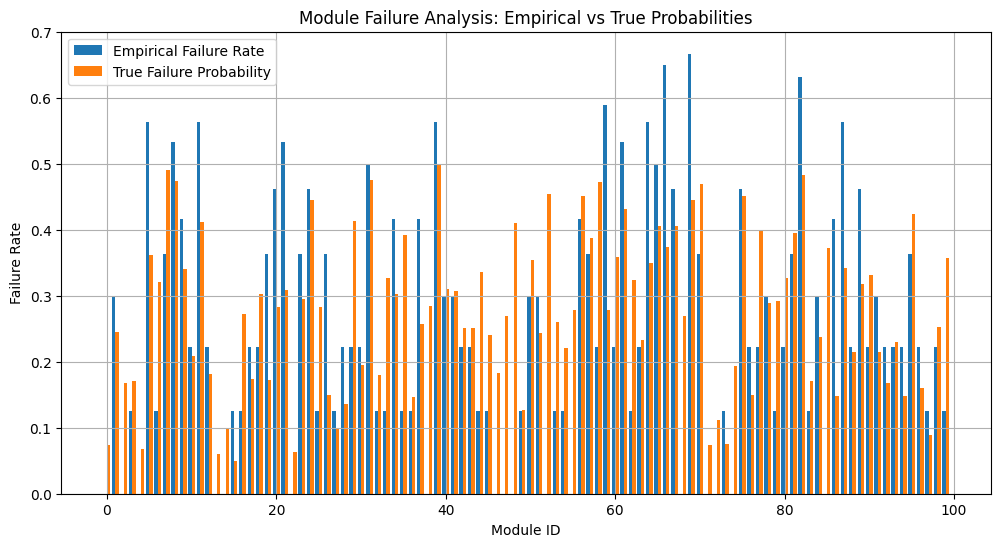

In [38]:
plot_module_failure_rates(module_rewards, module_counts, true_probs)


In [39]:
# Step 13: Compute performance metrics

def compute_performance_metrics(rl_results, random_results):

    rl_rewards = np.array(rl_results["rewards_over_time"])
    rand_rewards = np.array(random_results["rewards_over_time"])

    # 1. Total failures detected
    rl_total_failures = rl_rewards.sum()
    rand_total_failures = rand_rewards.sum()

    # 2. Detection efficiency
    rl_efficiency = rl_total_failures / len(rl_rewards)
    rand_efficiency = rand_total_failures / len(rand_rewards)

    # 3. Coverage speed (episodes to reach 100%)
    rl_coverage = np.array(rl_results["coverage_over_time"])
    rand_coverage = np.array(random_results["coverage_over_time"])

    rl_full_cov_step = np.argmax(rl_coverage == 100)
    rand_full_cov_step = np.argmax(rand_coverage == 100)

    # 4. High-risk module prioritization
    rl_agent = rl_results["rl_agent"]
    test_counts = rl_agent.module_counts
    true_probs = rl_results["system"].reveal_failure_probs()

    # Weighted correlation between module test freq and true risk
    prioritization_score = np.corrcoef(test_counts, true_probs)[0, 1]

    return {
        "rl_total_failures": rl_total_failures,
        "rand_total_failures": rand_total_failures,
        "rl_efficiency": rl_efficiency,
        "rand_efficiency": rand_efficiency,
        "rl_full_cov_step": rl_full_cov_step,
        "rand_full_cov_step": rand_full_cov_step,
        "prioritization_score": prioritization_score
    }


In [40]:
metrics = compute_performance_metrics(results, random_results)
metrics


{'rl_total_failures': np.int64(308),
 'rand_total_failures': np.int64(264),
 'rl_efficiency': np.float64(0.308),
 'rand_efficiency': np.float64(0.264),
 'rl_full_cov_step': np.int64(99),
 'rand_full_cov_step': np.int64(542),
 'prioritization_score': np.float64(0.5327577493684538)}

In [41]:
# Step 14: Multiple runs for robustness analysis

def run_multiple_seeds(num_seeds=10, num_modules=10, episodes=1000):

    rl_failure_totals = []
    rand_failure_totals = []
    prioritization_scores = []

    for seed in range(num_seeds):
        np.random.seed(seed)

        # Run RL
        rl_results = train_failure_detection_system(
            num_modules=num_modules,
            episodes=episodes
        )

        # Run Random
        rand_results = run_random_baseline(
            num_modules=num_modules,
            episodes=episodes
        )

        # Compute metrics
        metrics = compute_performance_metrics(rl_results, rand_results)

        rl_failure_totals.append(metrics["rl_total_failures"])
        rand_failure_totals.append(metrics["rand_total_failures"])
        prioritization_scores.append(metrics["prioritization_score"])

    return {
        "rl_failures": rl_failure_totals,
        "rand_failures": rand_failure_totals,
        "prior_scores": prioritization_scores
    }


In [42]:
multi_results = run_multiple_seeds(num_seeds=10)
multi_results


{'rl_failures': [np.int64(390),
  np.int64(242),
  np.int64(238),
  np.int64(319),
  np.int64(392),
  np.int64(369),
  np.int64(326),
  np.int64(368),
  np.int64(350),
  np.int64(188)],
 'rand_failures': [np.int64(211),
  np.int64(223),
  np.int64(236),
  np.int64(227),
  np.int64(289),
  np.int64(298),
  np.int64(311),
  np.int64(260),
  np.int64(295),
  np.int64(287)],
 'prior_scores': [np.float64(0.921668404064998),
  np.float64(0.9156138865968023),
  np.float64(0.7568842141958173),
  np.float64(0.8699542938277681),
  np.float64(0.8989143162573858),
  np.float64(0.9279356346577202),
  np.float64(0.8864477658525218),
  np.float64(0.7953074370198454),
  np.float64(0.8735447641241613),
  np.float64(0.9153697414920302)]}

In [43]:
import numpy as np

def summarize_multi_run_results(multi_results):
    print("\n=== Multi-run Evaluation Summary ===")

    rl_mean = np.mean(multi_results["rl_failures"])
    rl_std = np.std(multi_results["rl_failures"])

    rand_mean = np.mean(multi_results["rand_failures"])
    rand_std = np.std(multi_results["rand_failures"])

    prior_mean = np.mean(multi_results["prior_scores"])
    prior_std = np.std(multi_results["prior_scores"])

    print(f"RL Mean Failures Found: {rl_mean:.2f} ± {rl_std:.2f}")
    print(f"Random Mean Failures Found: {rand_mean:.2f} ± {rand_std:.2f}")
    print(f"Prioritization Score (Mean): {prior_mean:.2f} ± {prior_std:.2f}")


In [45]:
summarize_multi_run_results(multi_results)



=== Multi-run Evaluation Summary ===
RL Mean Failures Found: 318.20 ± 67.77
Random Mean Failures Found: 263.70 ± 34.84
Prioritization Score (Mean): 0.88 ± 0.05


In [46]:
multi_results_200 = run_multiple_seeds(num_seeds=200)
summarize_multi_run_results(multi_results_200)


=== Multi-run Evaluation Summary ===
RL Mean Failures Found: 346.30 ± 44.91
Random Mean Failures Found: 276.47 ± 43.86
Prioritization Score (Mean): 0.87 ± 0.06
